<a href="https://colab.research.google.com/github/Pepcoders/Data-Science-December/blob/main/22-02-07-Ensemble/Ensemble_December.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ask a complex question to thousands of random people, then aggregate
their answers. In many cases you will find that this aggregated answer is better than
an expert’s answer.**

A group of predictors is called an **ensemble**; thus, this technique is called **Ensemble Learning**, and an
Ensemble Learning algorithm is called an **Ensemble method**.

The most popular Ensemble methods, including 

*   Voting
    * Hard
    * Soft
*   bagging
    * Random Forest 
*   boosting
*   stacking
*   Cascading

We will also explore Random Forests.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# VotingClassifier

In [2]:
from sklearn.datasets import make_moons

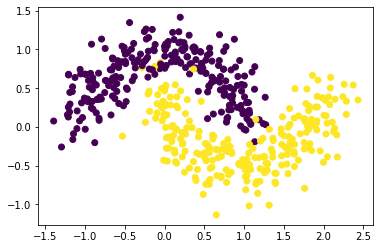

In [24]:
X, y = make_moons(noise = 0.2, n_samples=500, shuffle = True)

plt.scatter(X[:, 0], X[:, 1], c = y)

In [4]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y)

In [5]:
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((375, 2), (375,), (125, 2), (125,))

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

log = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
nb = GaussianNB()
svc = SVC()

## Hard

Majority Vote

In [7]:
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier([
                  ('logistic', log),
                  ('neighbour', knn),
                  ('tree', dt),
                  ('nb', nb),
                  ('svm', svc)
], n_jobs=-1)

In [8]:
vot.fit(X, y)
vot.score(X, y)

0.964

In [9]:
base = [log, knn, dt, nb, svc, vot]

for model in base:
    model.fit(xtrain, ytrain)
    sc = model.score(xtest, ytest)
    print(model.__class__.__name__, sc)

LogisticRegression 0.92
KNeighborsClassifier 0.936
DecisionTreeClassifier 0.928
GaussianNB 0.912
SVC 0.936
VotingClassifier 0.944


## Soft

probability

In [10]:
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier([
                  ('logistic', log),
                  ('neighbour', knn),
                  ('tree', dt),
                  ('nb', nb),
                  ('svm', SVC(probability=True))
], n_jobs=-1, voting='soft')

In [11]:
base = [log, knn, dt, nb, svc, vot]

for model in base:
    model.fit(xtrain, ytrain)
    sc = model.score(xtest, ytest)
    print(model.__class__.__name__, sc)

LogisticRegression 0.92
KNeighborsClassifier 0.936
DecisionTreeClassifier 0.928
GaussianNB 0.912
SVC 0.936
VotingClassifier 0.944


# **Bagging and Pasting**

Above we saw base model's of very different training algorithms.

Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set.

When sampling is performed with replacement, this method is called **bagging** (short for **bootstrap aggregating**), bagging does row sampling.

When sampling is performed without replacement, it is called **pasting**.

![image.png](https://raw.githubusercontent.com/aman5898/Pepcoding-Data-Science/main/Chapter%20Notes/7_Ensembler/assets/row_sampling.png)




**Generating DataSet**

You can ignore below cell.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50  # Number of datasets
n_train = 50  # Size of the training set
n_test = 1000  # Size of the test set
noise = 0.1  # Standard deviation of the noise
np.random.seed(0)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-(x ** 2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_trains = []
y_trains = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_trains.append(X)
    y_trains.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

In [13]:
len(X_trains), len(y_trains)

(50, 50)

In [14]:
len(X_trains[0]), len(y_trains[0])

(50, 50)

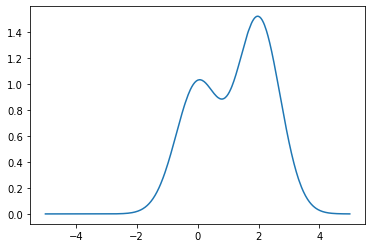

In [15]:
plt.plot(X_test, f(X_test))
plt.show()

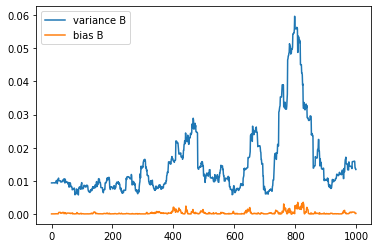

In [16]:
from sklearn.tree import DecisionTreeRegressor
MB = DecisionTreeRegressor()

y_pred = np.zeros( (n_test, n_repeat) )

for i in range(n_repeat):
    MB.fit(X_trains[i], y_trains[i])
    y_pred[:, i] = MB.predict(X_test)

varianceB = np.var(y_pred, axis = 1)
biasB = (f(X_test) - np.mean(y_pred, axis = 1))**2

plt.plot(varianceB, label = 'variance B')
plt.plot(biasB, label = 'bias B')
plt.legend()
plt.show()

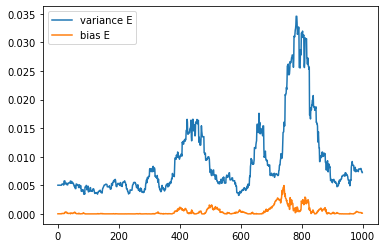

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

ME = BaggingRegressor()

y_pred = np.zeros( (n_test, n_repeat) )

for i in range(n_repeat):
    ME.fit(X_trains[i], y_trains[i])
    y_pred[:, i] = ME.predict(X_test)

varianceE = np.var(y_pred, axis = 1)
biasE = (f(X_test) - np.mean(y_pred, axis = 1))**2

plt.plot(varianceE, label = 'variance E')
plt.plot(biasE, label = 'bias E')
plt.legend()
plt.show()

## **Reduces Variance**

**Variance** Model changes a lot with sampling DataSet.

In bagging changing a sub-set to test-instances only few models change and dosent affect's result much.

Bagging can reduce variance without change in bias.

bagging can combine **low bias high variance** models and convert them to **low bias reduced variance** model.

Example of low bias and high variance ALGO is DT.

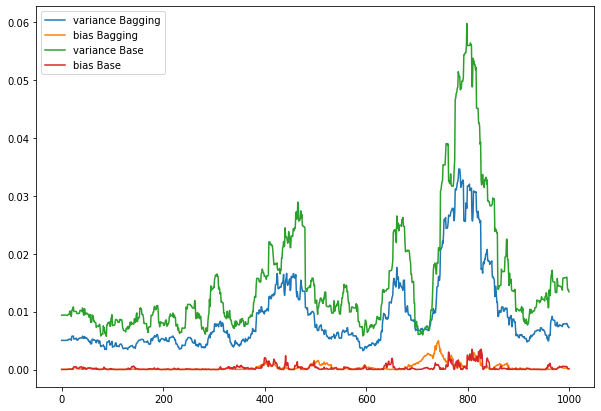

In [18]:
plt.figure(figsize = (10, 7))

plt.plot(varianceE, label = 'variance Bagging')
plt.plot(biasE, label = 'bias Bagging')
plt.plot(varianceB, label = 'variance Base')
plt.plot(biasB, label = 'bias Base')
plt.legend()
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

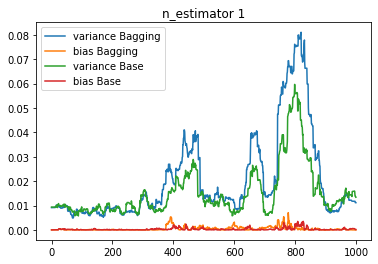

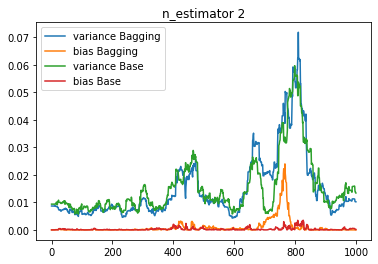

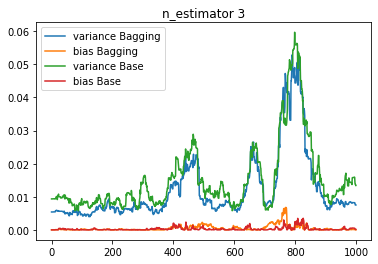

KeyboardInterrupt: 

In [19]:
from tqdm.notebook import tqdm

for be in tqdm(range(1, 10)):
    
    ME = BaggingRegressor(n_estimators=be, n_jobs=-1)

    y_pred = np.zeros( (n_test, n_repeat) )

    for i in range(n_repeat):
        ME.fit(X_trains[i], y_trains[i])
        y_pred[:, i] = ME.predict(X_test)

    varianceE = np.var(y_pred, axis = 1)
    biasE = (f(X_test) - np.mean(y_pred, axis = 1))**2

    plt.title('n_estimator {}'.format(be))
    plt.plot(varianceE, label = 'variance Bagging')
    plt.plot(biasE, label = 'bias Bagging')
    plt.plot(varianceB, label = 'variance Base')
    plt.plot(biasB, label = 'bias Base')
    plt.legend()
    plt.show()

# Pasting

`bootstrap = False`

sampling without replacement

# **Random Forest**

Random Forests = `DecisionTree + Bagging(row sampling) +  feature bagging(column sampling)`


A Random Forest is an **ensemble of Decision Trees**. Generally
trained via the bagging method (or sometimes pasting).

Random Forest is optimised for Decesion Tree than BaggingClassifier.

In [ ]:
from sklearn.datasets import make_regression

features = 50

x_trains = np.zeros((50, n_train, features))
y_trains = np.zeros((50, n_train))

for i in enumerate(range(n_repeat)):
    X, y = make_regression(n_samples = n_train, n_features = features)
    x_trains[i, :, :] = X
    y_trains[i, :] = y

In [ ]:
x_test, y_test = make_regression(n_samples = n_test, n_features = features)

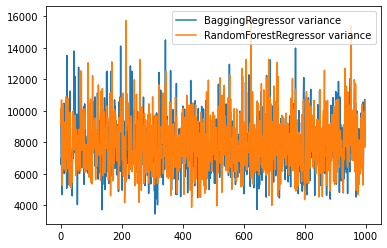

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

estimators = [
    BaggingRegressor(n_estimators = 10, n_jobs=-1),
    RandomForestRegressor(n_estimators = 10, n_jobs=-1)
]

def calBiasVar(model):
    y_pred = np.zeros( (x_test.shape[0], n_repeat) )

    for i in range(n_repeat):
        model.fit(x_trains[i], y_trains[i])
        y_pred[:, i] = model.predict(x_test)

    varianceE = np.var(y_pred, axis = 1)
    biasE = (y_test - np.mean(y_pred, axis = 1))**2

    plt.plot(varianceE, label = model.__class__.__name__ + ' variance')
    # plt.plot(biasE, label = model.__class__.__name__ + ' bias')

for model in estimators:
    calBiasVar(model)

plt.legend()
plt.show()

## **Extra-Trees**

ExtraTreesClassifier = `row_sampling + col_sampling + randomized_selection_TAU`

Because of **randomized_selection_TAU** variance is reduced even more than RandomForest.

Using **random thresholds** for each feature rather than searching for the best possible thresholds(like regular Decision Trees do) is simply called an **Extremely Randomized Trees** ensemble.

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

# Boosting

# AdaBoost

In [ ]:
from sklearn.datasets import make_circles

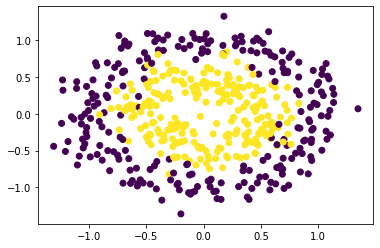

In [ ]:
X, y = make_circles(n_samples = 500, noise = 0.15, factor = 0.5)
plt.scatter(X[:, 0], X[:, 1], c = y)

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf = AdaBoostClassifier()
tree = DecisionTreeClassifier(max_depth=1)

In [ ]:
clf.fit(xtrain, ytrain)
tree.fit(xtrain, ytrain)

DecisionTreeClassifier(max_depth=1)

In [ ]:
print('Test', clf.score(xtest, ytest))
print('Train', clf.score(xtrain, ytrain))

Test 0.84
Train 1.0


In [ ]:
print('Test', tree.score(xtest, ytest))
print('Train', tree.score(xtrain, ytrain))

Test 0.6
Train 0.68


## Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(warm_start = True)
# gbc.fit(xtrain, ytrain)

In [ ]:
gbc.n_estimators = 0

trainerr = []
testerr = []

for i in tqdm(range(1, 200)):
    gbc.n_estimators += 1

    gbc.fit(xtrain, ytrain)
    trainerr.append(gbc.score(xtrain, ytrain))
    testerr.append(gbc.score(xtest, ytest))

  0%|          | 0/199 [00:00<?, ?it/s]

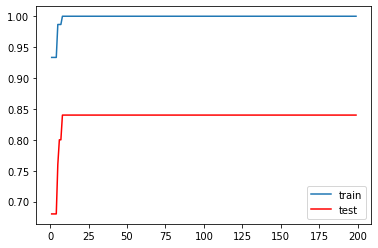

In [ ]:
plt.plot(np.arange(1, len(testerr)+1), trainerr, label = 'train')
plt.plot(np.arange(1, len(testerr)+1), testerr, label = 'test', color = 'r')

plt.legend()
plt.show()

In [ ]:
trainerr = []
testerr = []
lr = []

for i in tqdm(np.linspace(0.005, 1, 20)):
    gbc = GradientBoostingClassifier(learning_rate = i)

    lr.append(i)
    gbc.fit(xtrain, ytrain)
    trainerr.append(gbc.score(xtrain, ytrain))
    testerr.append(gbc.score(xtest, ytest))

  0%|          | 0/20 [00:00<?, ?it/s]

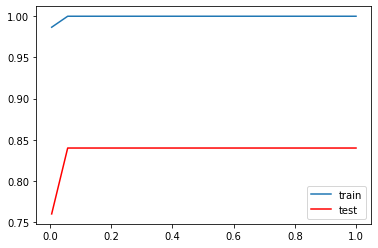

In [ ]:
plt.plot(lr, trainerr, label = 'train')
plt.plot(lr, testerr, label = 'test', color = 'r')

plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


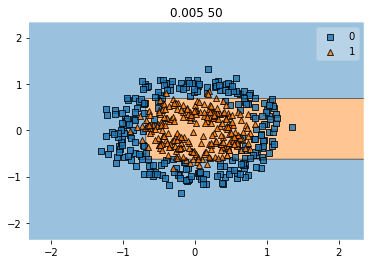

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


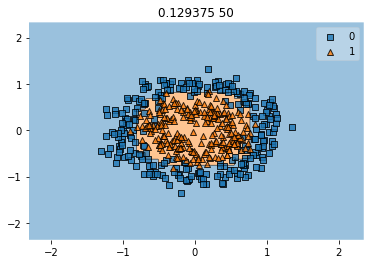

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


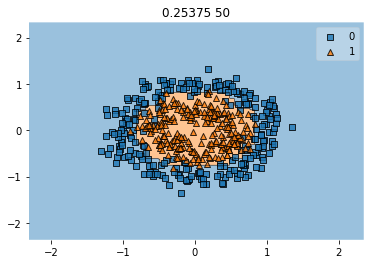

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


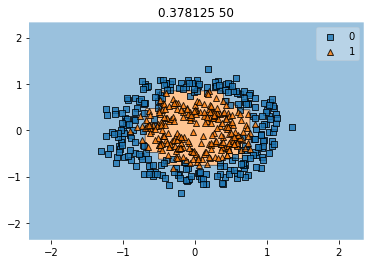

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


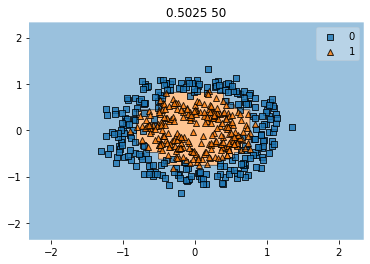

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


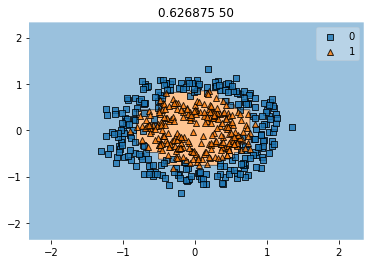

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


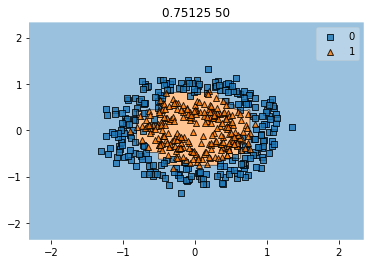

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


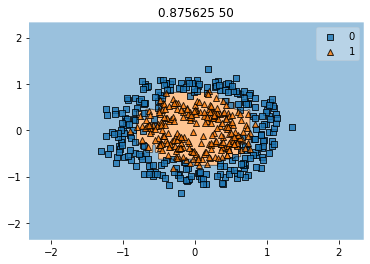

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


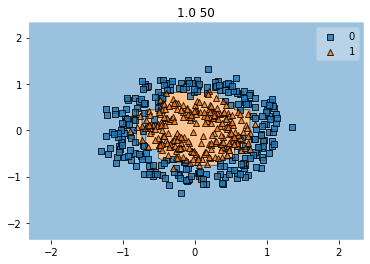

In [ ]:
from mlxtend.plotting import plot_decision_regions

# plt.subplot(3, 3, 1)
# plt.figure(figsize = (10, 25))
for i, lr in enumerate(np.linspace(0.005, 1, 9)):
    # plt.subplot(3, 3, i+1)
    clf = AdaBoostClassifier(learning_rate = lr)
    clf.fit(X, y)
    plot_decision_regions(X, y, clf = clf)
    plt.title('{} {}'.format(lr, clf.n_estimators))
    plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


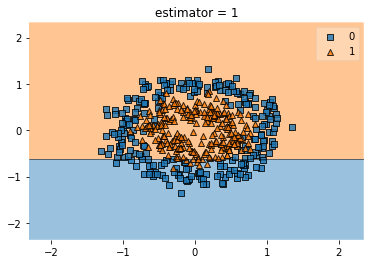

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


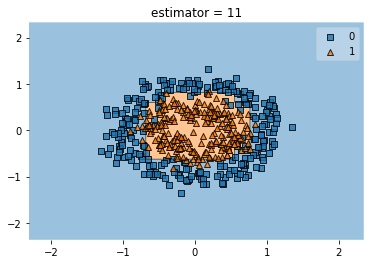

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


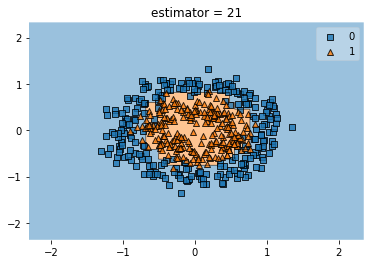

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


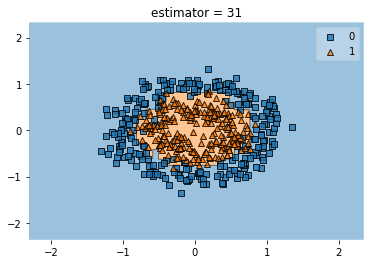

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


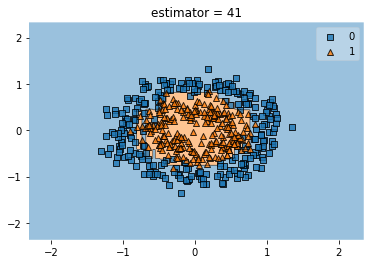

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


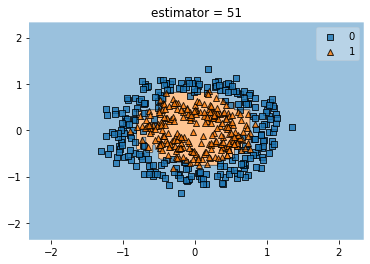

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


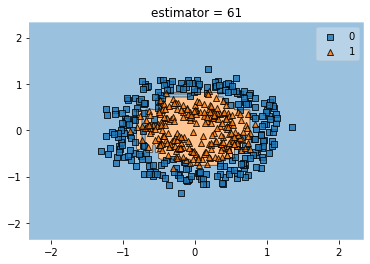

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


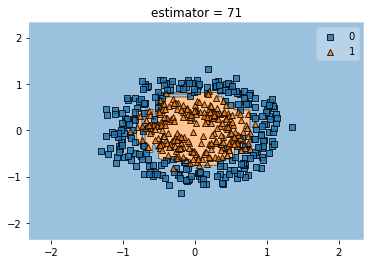

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


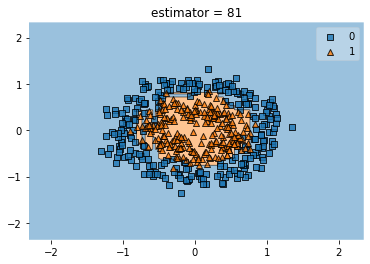

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


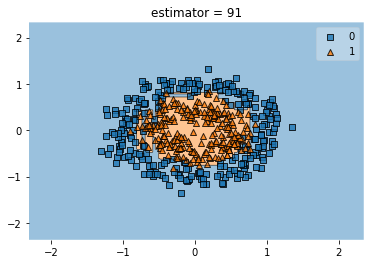

In [ ]:
from mlxtend.plotting import plot_decision_regions

# plt.subplot(3, 3, 1)
# plt.figure(figsize = (10, 25))
for i, ne in enumerate(range(1, 100, 10)):
    # plt.subplot(3, 3, i+1)
    clf = AdaBoostClassifier(n_estimators = ne)
    clf.fit(X, y)
    plot_decision_regions(X, y, clf = clf)
    plt.title('estimator = {}'.format(clf.n_estimators))
    plt.show()

# Stacking

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50  # Number of datasets
n_train = 50  # Size of the training set
n_test = 1000  # Size of the test set
noise = 0.1  # Standard deviation of the noise
np.random.seed(0)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-(x ** 2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_trains = []
y_trains = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_trains.append(X)
    y_trains.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)
y_test = f(X_test)

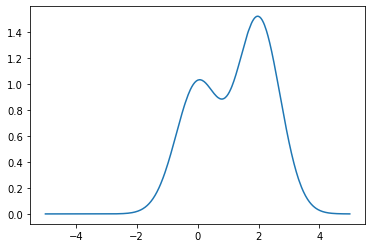

In [ ]:
plt.plot(X_test, y_test)

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


base_models = [
               ('tree', DecisionTreeRegressor()),
               (('svm'), SVR()),
               ('linear', LinearRegression()),
               ('nn', KNeighborsRegressor())
]

In [ ]:
sclf = StackingRegressor(
    estimators = base_models,
    final_estimator = GradientBoostingRegressor(),
    passthrough = True
  )

In [ ]:
models = [m[1] for m in base_models]
models.append(sclf)

In [ ]:
from sklearn.metrics import mean_squared_error

for model in models:
    model.fit(X_trains[0], y_trains[0])
    
    print(model.__class__.__name__, mean_squared_error(y_test, model.predict(X_test)))

DecisionTreeRegressor 0.011054491903595132
SVR 0.024114653229064895
LinearRegression 0.2150722369263764
KNeighborsRegressor 0.011028625481268692
StackingRegressor 0.03047071338095161
